## Aditya Jindal
## Batch W6
## Assignment 9
## _Gradient weighted Class Activation Map  and Cutout Augmentation Implementation_

In [0]:
# Importing all the required libraries from the modules

from keras import backend as K
import time
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import *
from keras.utils import np_utils

In [125]:
# Loading a database and getting unique number of classes
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print(num_classes)
print(train_features.shape)
print(test_features.shape)

10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


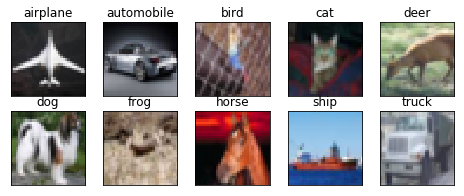

In [126]:
# Printing mentioned classes samples

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()



In [0]:
# Defining function to plot loss and accuracy for model
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to get accuracy on our test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Set/Convert all the pixel values to float data type 
# Normalizing all pixel values by dividing with 255 so that every value lies btw 0-1

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Converted the above 1-dimensional class label arrays to num_classes-dimensional class matrices
# As the test and train labels are not splitted into num_classes distinct labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [130]:
# Defining a model using Functional API of Keras
# Import library for functional API

from keras.models import Model
from keras.layers import Input
from keras.regularizers import l2

# Declaring regulariser value
kernel_l2 = 1e-5

input = Input(shape=(32,32,3))

ConvL1 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(input)
# Input for Layer 1 = (32x32x3)
# RF = 3
BNL1 = BatchNormalization()(ConvL1)
DL1 = SpatialDropout2D(0.05)(BNL1)

ConvL2 = Conv2D(128,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL1)
# Input for Layer 2 = (32x32x64)
# RF = 5
BNL2 = BatchNormalization()(ConvL2)
DL2 = SpatialDropout2D(0.05)(BNL2)

ConvPoint1 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL2)
# Input for BottleNeck Layer 1 = (32x32x128)
# RF = 5

MPL1 = MaxPooling2D(pool_size=(2, 2))(ConvPoint1)
# Input for BottleNeck Layer 1 = (32x32x32)
# RF = 10

ConvL3 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(MPL1)
# Input for Layer 3 = (16x16x32)
# RF = 12
BNL3 = BatchNormalization()(ConvL3)
DL3 = SpatialDropout2D(0.05)(BNL3)

ConvL4 = Conv2D(128,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL3)
# Input for Layer 4 = (16x16x64)
# RF = 14
BNL4 = BatchNormalization()(ConvL4)
DL4 = SpatialDropout2D(0.05)(BNL4)
 
ConvPoint2 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL4)
# Input for BottleNeck Layer 2 = (16x16x128)
# RF = 14

MPL2 = MaxPooling2D(pool_size=(2, 2))(ConvPoint2)
# Input for BottleNeck Layer 2 = (16x16x32)
# RF = 28

ConvL5 = Conv2D(64,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(MPL2)
BNL5 = BatchNormalization()(ConvL5)
DL5 = SpatialDropout2D(0.05)(BNL5)
# Input for Layer 5 = (8x8x32)
# RF = 30

ConvL6 = Conv2D(128,(3, 3), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL5)
BNL6 = BatchNormalization()(ConvL6)
DL6 = SpatialDropout2D(0.05)(BNL6)
# Input for Layer 6 = (8x8x64)
# RF = 32

ConvPoint3 = Conv2D(32,(1, 1), activation='relu', kernel_regularizer=l2(kernel_l2), padding='same')(DL6)
# Input for BottleNeck Layer 3 = (8x8x128)
# RF = 32
 
ConvL7 = Conv2D(10,(3, 3))(ConvPoint3)
# Input for Layer 7 = (8x8x32)
# RF = 34

GAP = GlobalAveragePooling2D()(ConvL7)
# Input for Layer 8 = (6x6x10)

output = Activation('softmax')(GAP)
# Input for Out Layer = (,10)

#Initialising the Model
model_tuned = Model(inputs=[input], outputs=[output])
model_tuned.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 32, 32, 128)       0         
__________

In [131]:
#Mounting drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [0]:
# Compile the model
model_tuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Changing Learning rate based on monitored quantity
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.001, patience=3, verbose=1, 
             mode='max', min_delta=0.0001, min_lr=0.00001)

weights_path="/content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(weights_path, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_weights_only = False, period = 1)




W0625 16:17:33.940138 140668634421120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 49s 989us/step - loss: 1.2811 - acc: 0.5344 - val_loss: 1.3236 - val_acc: 0.5585

Epoch 00001: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-01-0.56.hdf5
Epoch 2/100
50000/50000 [==============================] - 44s 887us/step - loss: 0.8721 - acc: 0.6935 - val_loss: 0.9337 - val_acc: 0.6723

Epoch 00002: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-02-0.67.hdf5
Epoch 3/100
50000/50000 [==============================] - 44s 885us/step - loss: 0.7161 - acc: 0.7510 - val_loss: 1.1324 - val_acc: 0.6446

Epoch 00003: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-03-0.64.hdf5
Epoch 4/100
50000/50000 [==============================] - 44s 887us/step - loss: 0.6220 - acc: 0.7862 - val_loss: 0.8389 - val_acc: 0.7208

Epoch 00004: saving model to /content/gdrive/My Drive/EVA_Weights

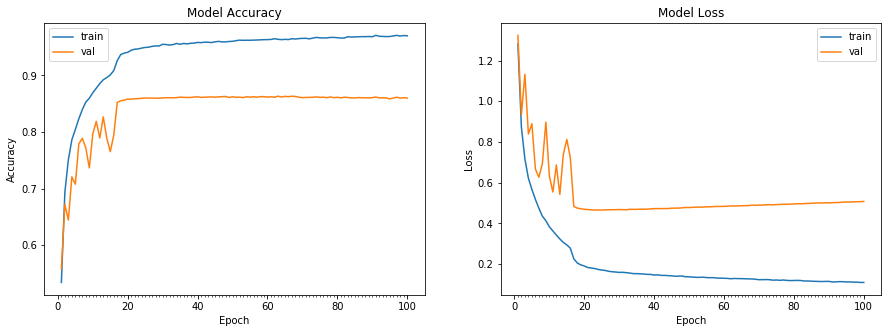

Accuracy on test data is: 85.98 


In [22]:
# Train the model
start = time.time()
model_info_tuned = model_tuned.fit(train_features, train_labels, batch_size = 128,
                                 epochs = 100,validation_data = (test_features, test_labels), verbose=1, callbacks = [checkpoint, reduce_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels, model_tuned))

In [0]:
# Loading Trained Model

model_tuned.load_weights("/content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-63-0.86.hdf5")

model_tuned.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
# GradCam function to create heatmap superimposed images with original images
def gradCam(img, layerName, out_channels):
  img1 = np.expand_dims(img, axis=0)
  
  preds = model_tuned.predict(img1)
  class_idx = np.argmax(preds[0])
  class_output = model_tuned.output[:, class_idx]
  last_conv_layer = model_tuned.get_layer(layerName)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_tuned.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255 * img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  cv2.waitKey(0)
  
  return superimposed_img

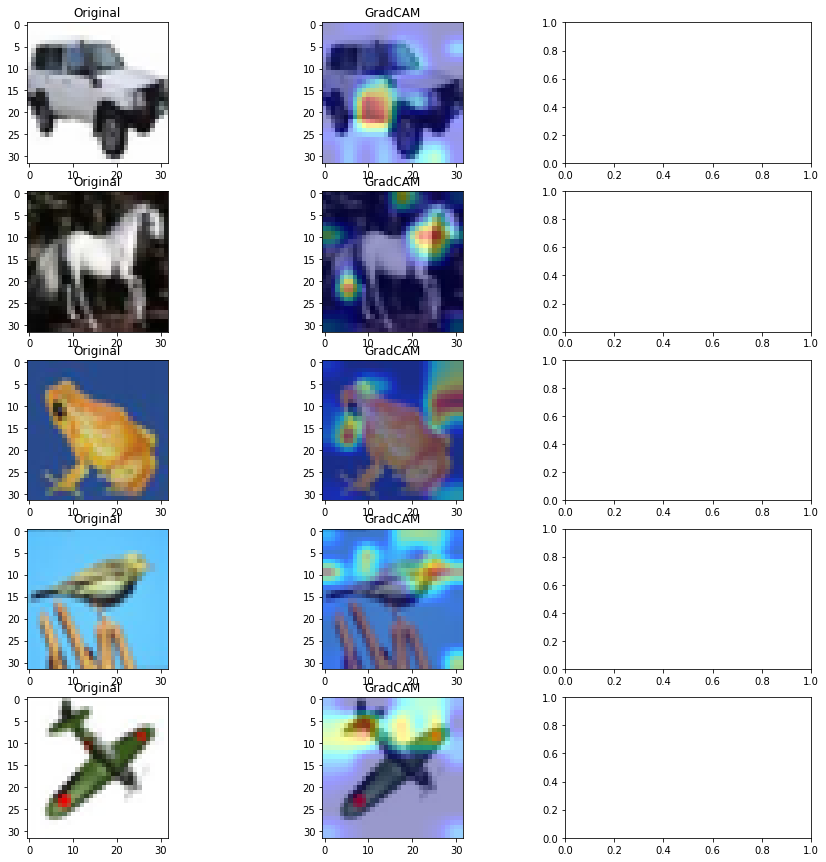

In [136]:
# Selecting images for gradCam test

test_img = [test_features[645], test_features[13], test_features[1245], test_features[67], test_features[98]]

fig, ax = plt.subplots(5, 3, figsize = (15, 15))
for num, i in enumerate(test_img):
    grad_img = gradCam(i, "conv2d_19", 32)
    ax[num,0].set_title("Original")
    ax[num,0].imshow(i)
    ax[num,1].set_title("GradCAM")
    ax[num,1].imshow(grad_img)
plt.show()

## Implementing CutOut Augmentation
### Part 9B

In [0]:
# Defining Random Eraser function for aug

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        
        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


W0626 17:30:31.853360 139728440227712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
390/390 [==============================] - 23s 59ms/step - loss: 0.4921 - acc: 0.8348 - val_loss: 0.9738 - val_acc: 0.7425

Epoch 00001: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-01-0.74.hdf5
Epoch 2/100
390/390 [==============================] - 21s 53ms/step - loss: 0.4528 - acc: 0.8482 - val_loss: 0.5945 - val_acc: 0.8185

Epoch 00002: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-02-0.82.hdf5
Epoch 3/100
390/390 [==============================] - 20s 52ms/step - loss: 0.4382 - acc: 0.8531 - val_loss: 0.5636 - val_acc: 0.8267

Epoch 00003: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-03-0.83.hdf5
Epoch 4/100
390/390 [==============================] - 21s 53ms/step - loss: 0.4283 - acc: 0.8566 - val_loss: 0.5236 - val_acc: 0.8414

Epoch 00004: saving model to /content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-04-0.84.hdf5
Epoch 5/100
390/390 [=======

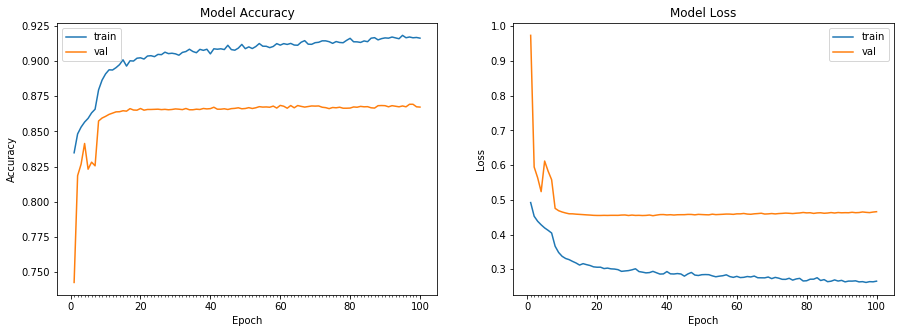

Accuracy on test data is: 86.73 


In [138]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

# Train the model with cutout augmentation
start = time.time()
model_info_tuned = model_tuned.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]//128, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = [checkpoint, reduce_lr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels, model_tuned))

In [0]:
# Loading Trained Model with Cutout

model_tuned.load_weights("/content/gdrive/My Drive/EVA_Weights/gradcam/weights-improvement-100-0.87.hdf5")

model_tuned.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


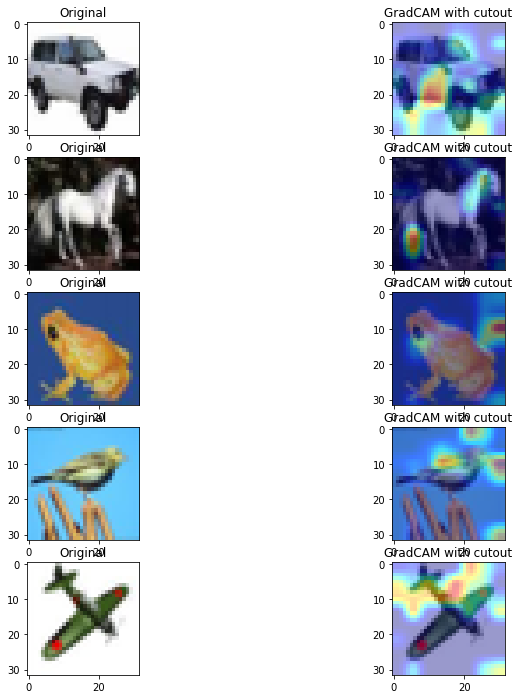

In [146]:
# Displaying test images, with gradCam, with gradCam and cutout

test_img_new = [test_features[645], test_features[13], test_features[1245], test_features[67], test_features[98]]

fig, ax = plt.subplots(5, 2, figsize = (12, 12))
for num, i in enumerate(test_img_new):
    grad_img = gradCam(i, "conv2d_19", 32)
    ax[num,0].set_title("Original")
    ax[num,0].imshow(i)
    ax[num,1].set_title("GradCAM with cutout")
    ax[num,1].imshow(grad_img)
plt.show()